# 20 News Groups Benchmark
## Sequence2class Model - No Hidden Layer

La prima parte del benchmark viene effettuata con un modello denominato **sequence2class** che consiste in una rete neurale composta da un layer di **EMBEDDING** in input ad una **rete RNN (LSTM)** incaricata di apprendere gli embedding associati alle sequenze in input (preventivamente pre-processate con tecniche di NLP quali stemming, stopwording, lemmatizaztion, tokenization, sequencing etc...). L'uscita della rete LSTM va in input ad un **rete neurale** (incaricata della classificazione), composta da un layer di output con 20 unità corrispondenti ai 20newsgroups. 

Il modello è riassunto come segue:
<img src="./images/sequence2class_noHidden.png" alt="sequence2class" width="700" />

In [1]:
import warnings
import time
import tensorflow as tf

In [2]:
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
from utils import *
from plots import *

Using TensorFlow backend.


In [4]:
from keras.layers import Dense, Embedding, Dropout, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
MAX_SEQUENCE_LENGTH = 200     # lunghezza massima di una singola sequenza
EMBEDDING_DIM       = 300     # dimensione layer di embedding
LSTM_UNITS          = 150
VALIDATION_SPLIT    = 0.2
EPOCHS              = 50
BATCHES             = 32
NUM_CLASSES         = 20

In [6]:
# Load useful data
x_train           = loadPkl('x_train')
y_train           = loadPkl('y_train')
x_test            = loadPkl('x_test')
y_test            = loadPkl('y_test')

labels            = loadPkl('labels')
test_indicies     = loadPkl('test_indicies')
namesInLabelOrder = loadPkl('namesInLabelOrder')
word_index        = loadPkl('word_index')

## 1) Sequence2class 

In [7]:
'''
Costruiamo una rete neurale con un layer di embedding in ingresso ad una LSTM.
In uscita all LSTM mettiamo un MLP con un layer hidden e funzione
di attivazione lineare RELU ed un layer di output e funzione di 
attivazione SOFTMAX.
In questo caso i word embeddings sono appresi durante il fitting della rete
'''

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                               mode='auto',patience=3, verbose=2, 
                               restore_best_weights=False)

s2c_nh_model = Sequential()
s2c_nh_model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=True,
                        mask_zero=True))

s2c_nh_model.add(LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

s2c_nh_model.add(Dense(NUM_CLASSES, activation='softmax'))

s2c_nh_model.name = 'Sequence2Class - No Hidden'

s2c_nh_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])

print("Preparazione del modello...")
 
s2c_nh_model.summary()

Preparazione del modello...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          32159100  
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                3020      
Total params: 32,432,720
Trainable params: 32,432,720
Non-trainable params: 0
_________________________________________________________________


In [8]:
start_time = time.time()

s2c_nh_history = s2c_nh_model.fit(x=x_train,y=y_train,
                            epochs=EPOCHS,
                            batch_size=BATCHES,
                            shuffle=True,
                            validation_data=(x_test,y_test),
                            callbacks=[early_stop])

elapsed_time = time.time() - start_time

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print ('Time Taken:')
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

savePkl('s2c_nh_history',s2c_nh_history)
savePkl('s2c_nh_model',s2c_nh_model)

Train on 14636 samples, validate on 3660 samples
Epoch 1/50
14636/14636 [==============================] - 644s 44ms/step - loss: 2.3572 - acc: 0.2522 - val_loss: 1.6881 - val_acc: 0.4224
Epoch 2/50
14636/14636 [==============================] - 696s 48ms/step - loss: 1.2154 - acc: 0.6002 - val_loss: 1.3461 - val_acc: 0.5604
Epoch 3/50
14636/14636 [==============================] - 599s 41ms/step - loss: 0.6695 - acc: 0.7924 - val_loss: 1.1297 - val_acc: 0.6667
Epoch 4/50
14636/14636 [==============================] - 609s 42ms/step - loss: 0.4007 - acc: 0.8815 - val_loss: 1.1895 - val_acc: 0.6721
Epoch 5/50
14636/14636 [==============================] - 689s 47ms/step - loss: 0.1937 - acc: 0.9472 - val_loss: 1.2671 - val_acc: 0.6740
Epoch 6/50
14636/14636 [==============================] - 678s 46ms/step - loss: 0.1041 - acc: 0.9751 - val_loss: 1.3338 - val_acc: 0.6776
Epoch 00006: early stopping
Time Taken:
01:05:16.05


### Preparing result & Plotting

In [9]:
result = {}

# loading model and history
s2c_nh_history       = loadPkl('s2c_history')
s2c_nh_model         = loadPkl('s2c_model')

# building result
result['history'] = s2c_nh_history.history
result['test_loss'], result['test_accuracy'] = s2c_nh_model.evaluate(x_test, y_test, verbose=2)

# testing model on validation data
prediction        = s2c_nh_model.predict(x_test, verbose=2)
prediction_labels = prediction.argmax(axis=1)

# building result
result['confusion_matrix'] = confusion_matrix(labels[test_indicies],prediction_labels).tolist()
result['classification_report'] = classification_report(labels[test_indicies],prediction_labels,digits=4,
                                                        target_names=namesInLabelOrder, output_dict=True)
# building confusion matrix
cm = result['confusion_matrix']
cm = np.array([np.array(xi) for xi in cm])

Generating confusion matrices...


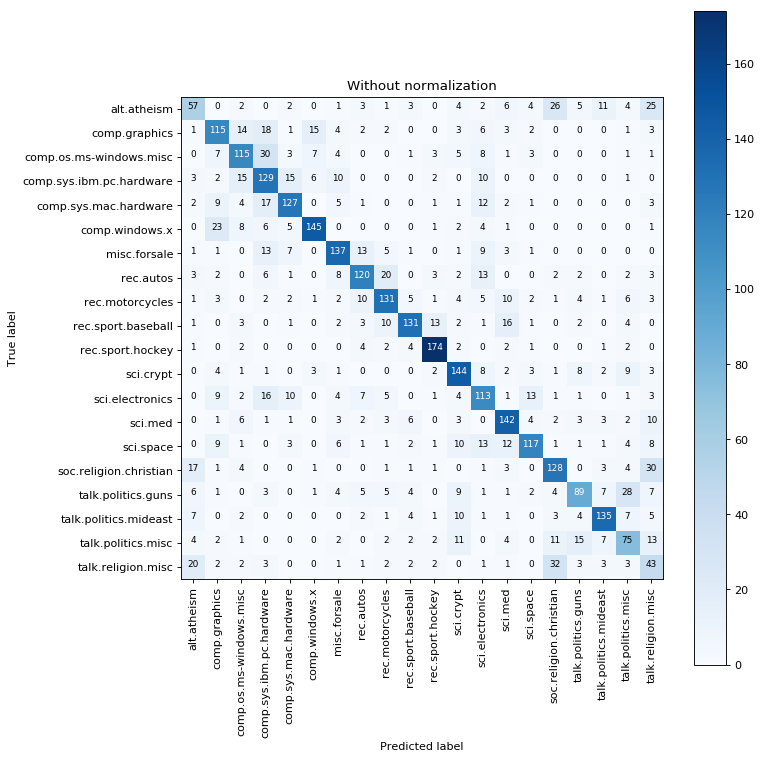

In [10]:
plot_confusion_matrix(cm, 's2c_nh_model', normalize=False, title='Without normalization')

Generating confusion matrices...


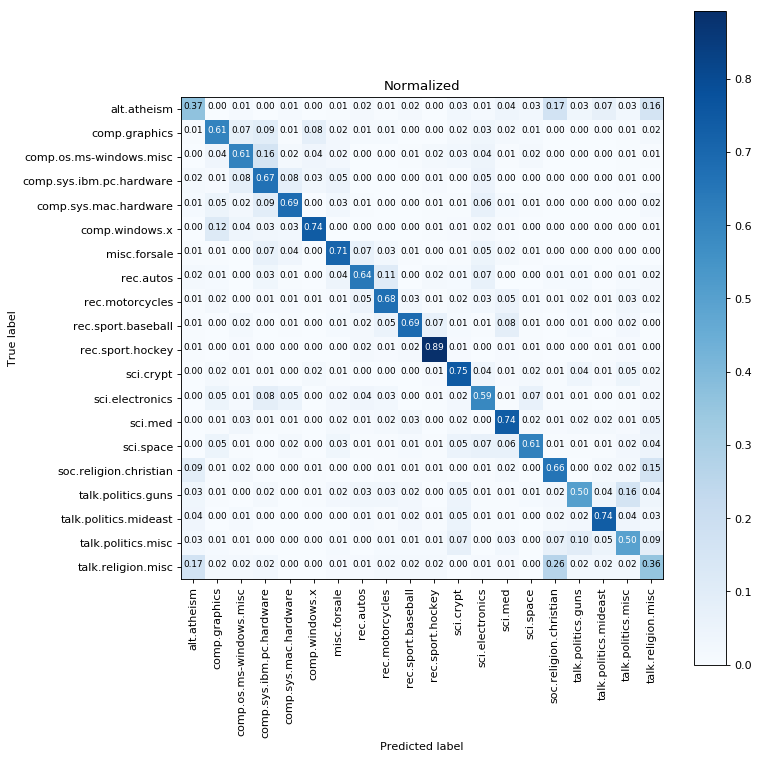

In [11]:
plot_confusion_matrix(cm, 's2c_nh_model', normalize=True, title='Normalized')

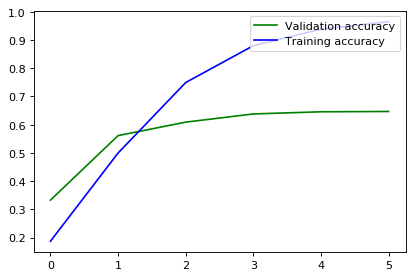

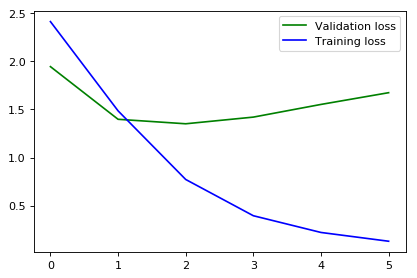

In [12]:
plotConvergence(result['history'],'s2c_nh_model')

## 2) Sequence2class 
### (GloVe Pre-Trained Word Embeddings)

In [13]:
'''
Costruiamo una rete neurale con un layer di embedding in ingresso ad una LSTM.
In uscita all LSTM mettiamo un MLP con un layer di output con 20 unità e funzione di 
attivazione SOFTMAX.
In questo caso i word embeddings non sono appresi durante il fitting della rete
ma utilizzano dei word embeddings pre calcolati presenti nella matrice 'embedding_matrix'
calcolata usando vettori di parole pre calcolati (GloVe: Global Vector by Stanford NLP Group) 
'''
embedding_matrix = getEmbeddingMatrix(word_index)

early_GlV_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                               mode='auto',patience=3, verbose=2, 
                               restore_best_weights=False)

s2c_GlV_nh_model = Sequential()
s2c_GlV_nh_model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH,
                        weights=[embedding_matrix],
                        trainable=False,
                        mask_zero=True))

s2c_GlV_nh_model.add(LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

s2c_GlV_nh_model.add(Dense(NUM_CLASSES, activation='softmax'))

s2c_GlV_nh_model.name = 'Sequence2Class - GlV No Hidden'

s2c_GlV_nh_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])

print("Preparazione del modello...")
 
s2c_GlV_nh_model.summary()

Preparazione del modello...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          32159100  
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                3020      
Total params: 32,432,720
Trainable params: 273,620
Non-trainable params: 32,159,100
_________________________________________________________________


In [14]:
start_time = time.time()

s2c_GlV_nh_history = s2c_GlV_nh_model.fit(x=x_train,y=y_train,
                            epochs=EPOCHS,
                            batch_size=BATCHES,
                            shuffle=True,
                            validation_data=(x_test,y_test),
                            callbacks=[early_GlV_stop])

elapsed_time = time.time() - start_time

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print ('Time Taken:')
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

savePkl('s2c_GlV_nh_history',s2c_GlV_nh_history)
savePkl('s2c_GlV_nh_model',s2c_GlV_nh_model)

Train on 14636 samples, validate on 3660 samples
Epoch 1/50
14636/14636 [==============================] - 307s 21ms/step - loss: 1.8816 - acc: 0.3875 - val_loss: 1.5301 - val_acc: 0.5128
Epoch 2/50
14636/14636 [==============================] - 321s 22ms/step - loss: 1.3614 - acc: 0.5569 - val_loss: 1.2265 - val_acc: 0.6087
Epoch 3/50
14636/14636 [==============================] - 298s 20ms/step - loss: 1.1219 - acc: 0.6422 - val_loss: 1.0838 - val_acc: 0.6552
Epoch 4/50
14636/14636 [==============================] - 283s 19ms/step - loss: 0.9878 - acc: 0.6867 - val_loss: 1.0289 - val_acc: 0.6790
Epoch 5/50
14636/14636 [==============================] - 283s 19ms/step - loss: 0.8664 - acc: 0.7244 - val_loss: 0.9785 - val_acc: 0.7033
Epoch 6/50
14636/14636 [==============================] - 284s 19ms/step - loss: 0.7911 - acc: 0.7454 - val_loss: 0.9609 - val_acc: 0.7068
Epoch 7/50
14636/14636 [==============================] - 283s 19ms/step - loss: 0.7127 - acc: 0.7706 - val_loss: 0.9

### Preparing result & Plotting

In [15]:
GlV_result = {}

# loading model and history
s2c_GlV_nh_history       = loadPkl('s2c_GlV_nh_history')
s2c_GlV_nh_model         = loadPkl('s2c_GlV_nh_model')

# building result
GlV_result['history'] = s2c_GlV_nh_history.history
GlV_result['test_loss'], GlV_result['test_accuracy'] = s2c_GlV_nh_model.evaluate(x_test, y_test, verbose=2)

# testing model on validation data
GlV_prediction        = s2c_GlV_nh_model.predict(x_test, verbose=2)
GlV_prediction_labels = GlV_prediction.argmax(axis=1)

# building result
GlV_result['confusion_matrix']      = confusion_matrix(labels[test_indicies],GlV_prediction_labels).tolist()
GlV_result['classification_report'] = classification_report(labels[test_indicies],GlV_prediction_labels,digits=4,
                                                        target_names=namesInLabelOrder, output_dict=True)

# building confusion matrix
GlV_cm = GlV_result['confusion_matrix']
GlV_cm = np.array([np.array(xi) for xi in GlV_cm])

Generating confusion matrices...


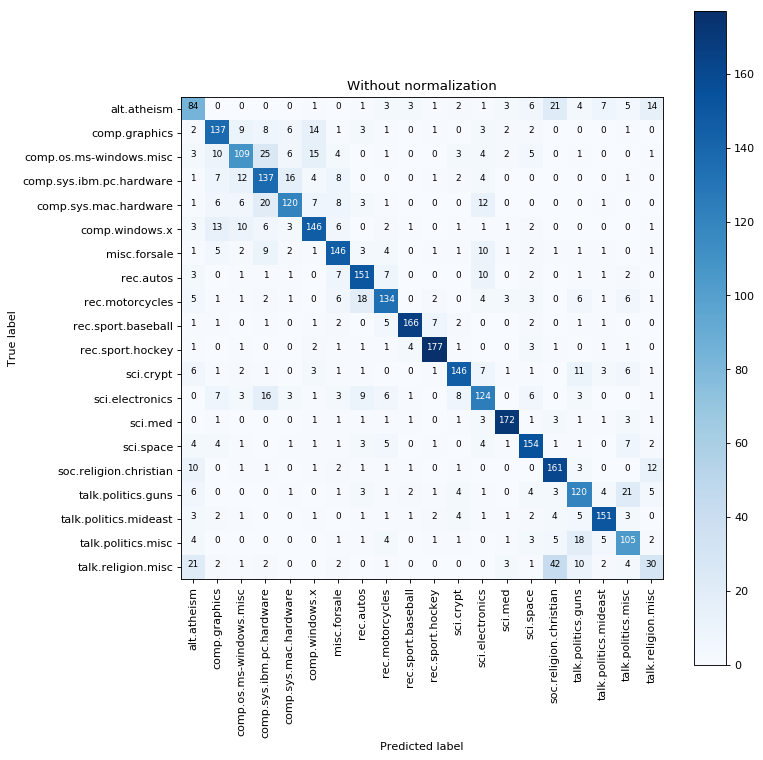

In [16]:
plot_confusion_matrix(GlV_cm, 's2c_GlV_nh_model', normalize=False, title='Without normalization')

Generating confusion matrices...


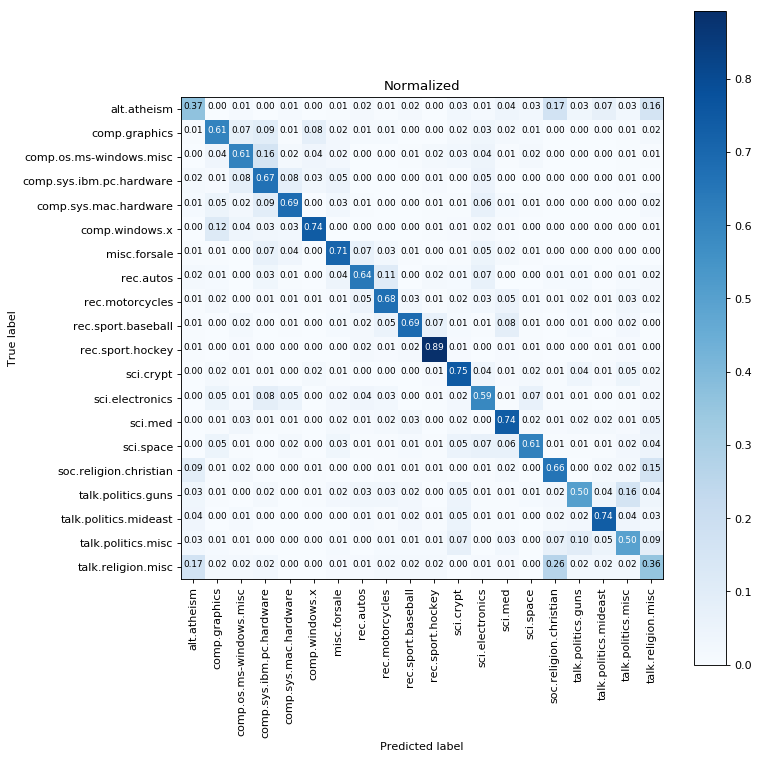

In [17]:
plot_confusion_matrix(cm, 's2c_GlV_nh_model', normalize=True, title='Normalized')

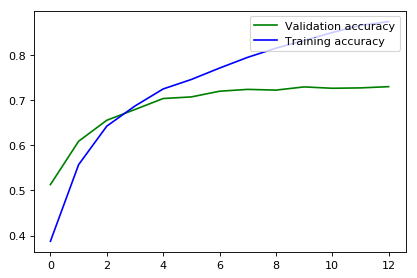

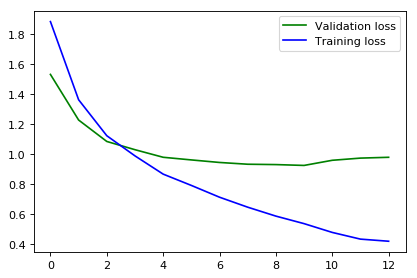

In [18]:
plotConvergence(GlV_result['history'],'s2c_GlV_nh_model')

## End